# **Multi-Layer Perceptron (MLP) for Regression**

This notebook provides a comprehensive implementation of a Multi-Layer Perceptron (MLP) neural network for regression tasks. It covers weight initialization, forward propagation, backpropagation for gradient computation, and the training process using mini-batch Gradient Descent. The Mean Squared Error (MSE) is used as the loss function, and the sigmoid function is employed as the activation for the hidden layer. This implementation is designed to be foundational, illustrating the core mechanics of neural network training from first principles.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Included for consistency, though not directly used in 1D MLP visualization

np.random.seed(42) # Set random seed for reproducibility


# **1. Helper Functions**

This section defines essential helper functions required for the MLP. These include activation functions and their derivatives, and the cost function used to quantify prediction error. Understanding these components is crucial for grasping the mathematical foundation of neural network training.

## **1.1 Sigmoid Activation Function**
The sigmoid function, also known as the logistic function, is a common choice for activation in hidden layers due to its S-shaped curve which squashes any real-valued input into a range between 0 and 1. This property is useful for introducing non-linearity into the network.

The sigmoid function is defined as:
$$ \sigma(z) = \frac{1}{1 + e^{-z}} $$

Its derivative, which is essential for backpropagation, can be conveniently expressed in terms of the function itself:
$$ \sigma'(z) = \sigma(z) (1 - \sigma(z)) $$

## **1.2 Mean Squared Error (MSE) Cost Function**

$$ J(\mathbf{W}, b) = \frac{1}{2B} \sum_{i=1}^{B} (y_i - \hat{y}_i)^2 $$
The factor of $1/2$ is often included for convenience, as it simplifies the derivative during backpropagation.

## **1.3 Regularization (L1 and L2)**
Regularization techniques are used to prevent overfitting by adding a penalty term to the cost function. This encourages the model to learn simpler mappings and reduces the complexity of the learned weights.

**L1 Regularization (Lasso):** Adds the sum of the absolute values of the weights to the cost function. It can lead to sparse models, effectively performing feature selection.
$$ R_{L1}(\mathbf{W}) = \frac{\lambda}{2} \sum_{j} |w_j| $$

**L2 Regularization (Ridge):** Adds the sum of the squares of the weights to the cost function. It encourages smaller weights, distributing the importance across all features.
$$ R_{L2}(\mathbf{W}) = \frac{\lambda}{2} \sum_{j} w_j^2 $$

Here, $\lambda$ is the regularization strength, controlling the impact of the penalty term. Note that bias terms are typically excluded from regularization.

In [ ]:
def MLP_sigmoid(z):
    """
    Computes the sigmoid activation function.

    Args:
        z (np.array): Input to the sigmoid function (scalar, vector, or matrix).

    Returns:
        np.array: Output of the sigmoid function, element-wise.
    """
    return 1.0 / (1.0 + np.exp(-z))

def MLP_sigmoid_derivative(rZ):
    """
    Computes the derivative of the sigmoid function.

    Args:
        rZ (np.array): Input to the sigmoid function (pre-activation values).

    Returns:
        np.array: Derivative of the sigmoid, element-wise, at rZ.
    """
    sigma_of_rZ = MLP_sigmoid(rZ)
    return sigma_of_rZ * (1.0 - sigma_of_rZ)

def MLP_MSE_cost(y_true, y_pred, model, W1, W2):
    """
    Computes the Mean Squared Error (MSE) cost function.

    Args:
        y_true (np.array): True target values (1xBatchSize or BatchSize x 1).
        y_pred (np.array): Predicted output values (1xBatchSize).
        model (dict): Dictionary containing model parameters (e.g., regularization lambdas).
        W1 (np.array): Weights matrix for the hidden layer.
        W2 (np.array): Weights matrix for the output layer.

    Returns:
        float: The scalar MSE cost.
    """
    # Ensure y_true has the same shape as y_pred for element-wise operations
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)

    cost = np.sum((y_true - y_pred)**2) / (2 * y_true.shape[1])

    # Optional: Add L1 and L2 regularization terms (commented out by default)
    # l1 = model.get('l1', 0)
    # l2 = model.get('l2', 0)
    # L1_term = L1_reg(l1, W1, W2)
    # L2_term = L2_reg(l2, W1, W2)
    # cost = cost + L1_term + L2_term

    return cost

def L2_reg(lambda_val, W1, W2):
    """
    Computes the L2 regularization cost.

    Args:
        lambda_val (float): Regularization strength.
        W1 (np.array): Weights matrix for the hidden layer.
        W2 (np.array): Weights matrix for the output layer.

    Returns:
        float: The L2 regularization cost.
    """
    # Exclude bias terms (first column) from regularization
    cost = (lambda_val / 2.0) * (np.sum(W1[:, 1:]**2) + np.sum(W2[:, 1:]**2))
    return cost

def L1_reg(lambda_val, W1, W2):
    """
    Computes the L1 regularization cost.

    Args:
        lambda_val (float): Regularization strength.
        W1 (np.array): Weights matrix for the hidden layer.
        W2 (np.array): Weights matrix for the output layer.

    Returns:
        float: The L1 regularization cost.
    """
    # Exclude bias terms (first column) from regularization
    cost = (lambda_val / 2.0) * (np.sum(np.abs(W1[:, 1:])) + np.sum(np.abs(W2[:, 1:])))
    return cost


# **2. MLP Architecture Functions**

This section defines the core functions that constitute the MLP's architecture: weight initialization, the forward pass for computing predictions, and the backpropagation algorithm for calculating gradients. These functions are the building blocks for training and using the neural network.

## **2.1 Weight Initialization**
Proper initialization of weights is crucial for training neural networks effectively. Here, weights are initialized uniformly in the range $[-1, 1]$. This helps to break symmetry and ensures that neurons learn distinct features. Bias terms are incorporated directly into the weight matrices as an additional column, corresponding to an input feature that is always 1.

For a hidden layer with $H$ neurons and $D$ input features (plus bias), the weight matrix $W_1$ will have dimensions $(H \times (D+1))$.
For an output layer with $O$ neurons and $H$ hidden neurons (plus bias), the weight matrix $W_2$ will have dimensions $(O \times (H+1))$.

## **2.2 Forward Propagation**
The forward pass computes the network's output for a given input. It involves a series of matrix multiplications and activation function applications:

1.  **Input Layer to Hidden Layer:**
    * Augment input data $P_{input}$ with a bias term (a row of ones) to form $A_0$. If $P_{input}$ has shape $(B \times D)$, then $A_0$ will have shape $((D+1) \times B)$.
    * Compute the pre-activation for the hidden layer: $Z_1 = W_1 A_0$. The shape of $Z_1$ will be $(H \times B)$.
    * Apply the sigmoid activation function: $A_1 = \sigma(Z_1)$. The shape of $A_1$ will be $(H \times B)$.

2.  **Hidden Layer to Output Layer:**
    * Augment the hidden layer activations $A_1$ with a bias term (a row of ones) to form $A_1^{ext}$. If $A_1$ has shape $(H \times B)$, then $A_1^{ext}$ will have shape $((H+1) \times B)$.
    * Compute the output layer activations (predictions): $\hat{Y} = W_2 A_1^{ext}$. The shape of $\hat{Y}$ will be $(O \times B)$.

## **2.3 Backpropagation Algorithm**
Backpropagation is the algorithm used to efficiently compute the gradients of the loss function with respect to the network's weights. It works by propagating the error backwards through the network, layer by layer.

1.  **Output Layer Error ($ \delta_2 $):**
    * For MSE and a linear output layer, the error signal at the output pre-activation is simply the difference between prediction and true value:
        $$ \delta_2 = (\hat{Y} - Y_{true}) $$
    * Shape: $(O \times B)$.

2.  **Gradient for Output Weights ($ \nabla_{W_2} J $):**
    * The gradient with respect to $W_2$ is computed by multiplying the output error signal by the activated hidden layer values:
        $$ \nabla_{W_2} J = \delta_2 (A_1^{ext})^T $$
    * Shape: $(O \times (H+1))$.

3.  **Hidden Layer Error ($ \delta_1 $):**
    * The error signal is propagated back to the hidden layer. This involves multiplying the output error by the transpose of the output weights, and then element-wise multiplying by the derivative of the hidden layer's activation function:
        $$ \delta_1 = (W_2^T \delta_2)_{\text{excluding bias}} \odot \sigma'(Z_1) $$
    * Shape: $(H \times B)$.

4.  **Gradient for Hidden Weights ($ \nabla_{W_1} J $):**
    * The gradient with respect to $W_1$ is computed by multiplying the hidden layer error signal by the augmented input values:
        $$ \nabla_{W_1} J = \delta_1 A_0^T $$
    * Shape: $(H \times (D+1))$.

These gradients are then used in the Gradient Descent update rule to adjust the weights.

In [ ]:
def MLP_initialize_weights(model):
    """
    Initializes weights for a two-layer MLP with values uniformly distributed in [-1, 1].
    Bias terms are included in the weight matrices as the first column.

    Args:
        model (dict): Dictionary containing network dimensions (n_hidden, n_features, n_output).

    Returns:
        tuple: W1 (np.array) - Weights for hidden layer, W2 (np.array) - Weights for output layer.
    """
    n_hidden = model['n_hidden']
    n_features = model['n_features']
    n_output = model['n_output']

    # W1: (n_hidden x (n_features + 1)) matrix, including bias for hidden layer
    # The +1 accounts for the bias term which will be multiplied by a constant 1 in the input A0
    W1 = 2 * np.random.rand(n_hidden, n_features + 1) - 1

    # W2: (n_output x (n_hidden + 1)) matrix, including bias for output layer
    # The +1 accounts for the bias term which will be multiplied by a constant 1 in the activated hidden layer A1
    W2 = 2 * np.random.rand(n_output, n_hidden + 1) - 1

    return W1, W2

def MLP_MSELIN_forward(P_input, W1, W2):
    """
    Performs the forward pass through the MLP.

    Args:
        P_input (np.array): Input patterns, where each row is an observation (BatchSize x n_features).
        W1 (np.array): Weights matrix for the hidden layer (n_hidden x (n_features + 1)).
        W2 (np.array): Weights matrix for the output layer (n_output x (n_hidden + 1)).

    Returns:
        tuple: rA2 (np.array) - Output layer activations (predictions),
               A1 (np.array) - Hidden layer activations with bias,
               A0 (np.array) - Input patterns with bias,
               rZ1 (np.array) - Hidden layer pre-activations.
    """
    batch_size = P_input.shape[0]

    # A0: Input patterns with bias term (column of ones) appended
    # Shape: (n_features + 1) x BatchSize
    A0 = np.vstack((np.ones(batch_size), P_input.T))

    # rZ1: Pre-activation values for the hidden layer
    # W1: n_hidden x (n_features + 1)
    # A0: (n_features + 1) x BatchSize
    # rZ1: n_hidden x BatchSize
    rZ1 = W1 @ A0

    # rA1: Activated values of the hidden layer
    # Shape: n_hidden x BatchSize
    rA1 = MLP_sigmoid(rZ1)

    # A1: Activated hidden layer values with bias term appended
    # Shape: (n_hidden + 1) x BatchSize
    A1 = np.vstack((np.ones(batch_size), rA1))

    # rA2: Output layer activations (predictions)
    # W2: n_output x (n_hidden + 1)
    # A1: (n_hidden + 1) x BatchSize
    # rA2: n_output x BatchSize
    rA2 = W2 @ A1

    return rA2, A1, A0, rZ1

def MLP_MSELIN_backprop(rA2, A1, A0, rZ1, Y_true, W1, W2):
    """
    Computes the partial derivatives of the loss with respect to the weight matrices W2 and W1
    using the backpropagation algorithm.

    Args:
        rA2 (np.array): Output layer activations (predictions) (n_output x BatchSize).
        A1 (np.array): Hidden layer activations with bias ( (n_hidden + 1) x BatchSize).
        A0 (np.array): Input patterns with bias ( (n_features + 1) x BatchSize).
        rZ1 (np.array): Hidden layer pre-activations (n_hidden x BatchSize).
        Y_true (np.array): True target values (n_output x BatchSize).
        W1 (np.array): Weights matrix for the hidden layer (n_hidden x (n_features + 1)).
        W2 (np.array): Weights matrix for the output layer (n_output x (n_hidden + 1)).

    Returns:
        tuple: delta_W1_unscaled (np.array) - Gradient for W1,
               delta_W2_unscaled (np.array) - Gradient for W2.
    """
    batch_size = A0.shape[1]

    # Step 1: Compute dL_dZ2 (error signal at the output layer pre-activation)
    # This is the derivative of the MSE loss with respect to the output layer's pre-activation Z2.
    # For MSE and linear output, dL/dZ2 = (rA2 - Y_true)
    # Shape: n_output x BatchSize
    dL_dZ2 = rA2 - Y_true

    # Step 2: Compute dL_dW2 (gradient for W2)
    # dL/dW2 = dL/dZ2 * A1.T (matrix multiplication)
    # W2: n_output x (n_hidden + 1)
    # dL_dZ2: n_output x BatchSize
    # A1.T: BatchSize x (n_hidden + 1)
    # dL_dW2: n_output x (n_hidden + 1)
    dL_dW2 = dL_dZ2 @ A1.T

    # Step 3: Compute dL_dA1 (error signal propagated back to hidden layer activations)
    # dL/dA1 = W2.T * dL/dZ2 (matrix multiplication)
    # W2.T: (n_hidden + 1) x n_output
    # dL_dZ2: n_output x BatchSize
    # dL_dA1: (n_hidden + 1) x BatchSize
    dL_dA1 = W2.T @ dL_dZ2

    # Step 4: Compute dL_drZ1 (error signal at hidden layer pre-activation)
    # This involves the derivative of the sigmoid activation function at the hidden layer.
    # dL/drZ1 = (dL/dA1 excluding bias) * sigmoid_derivative(rZ1) (element-wise multiplication)
    # dL_dA1[1:, :] extracts error signal for actual hidden units (excluding bias row)
    # sigma_prime_of_rZ1: n_hidden x BatchSize
    # dL_drZ1: n_hidden x BatchSize
    sigma_prime_of_rZ1 = MLP_sigmoid_derivative(rZ1)
    dL_drZ1 = dL_dA1[1:, :] * sigma_prime_of_rZ1

    # Step 5: Compute dL_dW1 (gradient for W1)
    # dL/dW1 = dL/drZ1 * A0.T (matrix multiplication)
    # W1: n_hidden x (n_features + 1)
    # dL_drZ1: n_hidden x BatchSize
    # A0.T: BatchSize x (n_features + 1)
    # dL_dW1: n_hidden x (n_features + 1)
    dL_dW1 = dL_drZ1 @ A0.T

    # Step 6: Apply regularization (if enabled - currently commented out)
    # These are the unscaled gradients before applying learning rate and momentum.
    delta_W1_unscaled = dL_dW1
    delta_W2_unscaled = dL_dW2

    # Example of regularization addition (if l1, l2 were active in model):
    # l1 = model.get('l1', 0)
    # l2 = model.get('l2', 0)
    # delta_W1_unscaled[:, 1:] += W1[:, 1:] * (l1 + l2) # For L1/L2 on non-bias weights
    # delta_W2_unscaled[:, 1:] += W2[:, 1:] * (l1 + l2) # For L1/L2 on non-bias weights

    return delta_W1_unscaled, delta_W2_unscaled

def MLP_MSELIN_predict(P_input, W1, W2):
    """
    Predicts the outputs for given input patterns using the trained MLP.

    Args:
        P_input (np.array): Input patterns, where each row is a distinct observation.
        W1 (np.array): Trained weights matrix for the hidden layer.
        W2 (np.array): Trained weights matrix for the output layer.

    Returns:
        np.array: Predicted outputs (n_output x BatchSize).
    """
    rA2, _, _, _ = MLP_MSELIN_forward(P_input, W1, W2)
    return rA2


# **3. MLP Training Function**

The `MLP_MSELIN_train` function orchestrates the entire training process. It initializes weights, then iterates through a specified number of epochs, processing data in mini-batches. For each mini-batch, it performs a forward pass, calculates the loss, computes gradients via backpropagation, and updates the weights using Gradient Descent. This iterative process aims to minimize the cost function and improve the model's predictive accuracy.

In [ ]:
def MLP_MSELIN_train(P_train, y_train, model):
    """
    Trains the Multi-Layer Perceptron model using mini-batch Gradient Descent.

    Args:
        P_train (np.array): Training input patterns (N_observations x n_features).
        y_train (np.array): True target values for training (N_observations x n_output).
        model (dict): Dictionary containing model configuration (eta, epochs, minibatches, etc.).

    Returns:
        tuple: model (dict) - Updated model dictionary with trained weights and cost history,
               W1 (np.array) - Trained weights for the hidden layer,
               W2 (np.array) - Trained weights for the output layer.
    """
    # Initialize weights
    W1, W2 = MLP_initialize_weights(model)

    eta = model['eta']
    epochs = model['epochs']
    minibatches = model['minibatches']

    # Initialize cost history
    model['cost_history'] = []

    # Momentum parameters (commented out by default)
    # delta_W1_prev = np.zeros_like(W1)
    # delta_W2_prev = np.zeros_like(W2)
    # alpha = model.get('alpha', 0) # Momentum coefficient

    num_observations = P_train.shape[0]

    for e in range(1, epochs + 1):
        # Optional: Adaptive learning rate (commented out)
        # decrease_const = model.get('decrease_const', 0)
        # current_eta = eta / (1 + decrease_const * e)
        current_eta = eta # Use fixed learning rate if adaptive is off

        # Shuffle data for each epoch
        shuffled_indices = np.random.permutation(num_observations)
        P_shuffled = P_train[shuffled_indices, :]
        y_shuffled = y_train[shuffled_indices, :]

        # Reshape indices for mini-batching
        # np.array_split handles cases where num_observations is not perfectly divisible by minibatches
        mini_batch_indices = np.array_split(np.arange(num_observations), minibatches)

        for m_idx, idx in enumerate(mini_batch_indices):
            # Extract mini-batch data
            P_mini_batch = P_shuffled[idx, :]
            y_mini_batch = y_shuffled[idx, :].T # Transpose y_mini_batch to match expected 1xBatchSize or n_output x BatchSize

            # Forward pass
            rA2, A1, A0, rZ1 = MLP_MSELIN_forward(P_mini_batch, W1, W2)

            # Compute cost
            cost = MLP_MSE_cost(y_mini_batch, rA2, model, W1, W2)
            model['cost_history'].append(cost)

            # Print progress
            print(f'Epoch {e}/{epochs}, Minibatch {m_idx+1}/{minibatches}, Loss (MSE) {cost:.6f}')

            # Compute gradient via backpropagation
            delta_W1_unscaled, delta_W2_unscaled = MLP_MSELIN_backprop(rA2, A1, A0, rZ1, y_mini_batch, W1, W2)

            # Update parameters using Gradient Descent
            delta_W1 = current_eta * delta_W1_unscaled
            delta_W2 = current_eta * delta_W2_unscaled

            W1 = W1 - delta_W1
            W2 = W2 - delta_W2

            # Optional: Apply momentum (commented out)
            # W1 = W1 - (delta_W1 + (alpha * delta_W1_prev))
            # W2 = W2 - (delta_W2 + (alpha * delta_W2_prev))
            # delta_W1_prev = delta_W1
            # delta_W2_prev = delta_W2

    model['W1'] = W1
    model['W2'] = W2
    return model, W1, W2


# **4. Model Definition and Training Example**

This section sets up the MLP model parameters, generates a synthetic dataset for a simple regression problem, trains the MLP using the `MLP_MSELIN_train` function, and visualizes the training loss and the model's predictions against the true data. This example demonstrates the practical application of the implemented MLP for learning a non-linear relationship from data.

Output streaming troncato alle ultime 5000 righe.
Epoch 1/500, Minibatch 2/10, Loss (MSE) 0.242199
Epoch 1/500, Minibatch 3/10, Loss (MSE) 0.323902
Epoch 1/500, Minibatch 4/10, Loss (MSE) 0.254565
Epoch 1/500, Minibatch 5/10, Loss (MSE) 0.334770
Epoch 1/500, Minibatch 6/10, Loss (MSE) 0.259489
Epoch 1/500, Minibatch 7/10, Loss (MSE) 0.258547
Epoch 1/500, Minibatch 8/10, Loss (MSE) 0.304920
Epoch 1/500, Minibatch 9/10, Loss (MSE) 0.340134
Epoch 1/500, Minibatch 10/10, Loss (MSE) 0.187503
Epoch 2/500, Minibatch 1/10, Loss (MSE) 0.360549
Epoch 2/500, Minibatch 2/10, Loss (MSE) 0.217465
Epoch 2/500, Minibatch 3/10, Loss (MSE) 0.250411
Epoch 2/500, Minibatch 4/10, Loss (MSE) 0.275460
Epoch 2/500, Minibatch 5/10, Loss (MSE) 0.230382
Epoch 2/500, Minibatch 6/10, Loss (MSE) 0.223701
Epoch 2/500, Minibatch 7/10, Loss (MSE) 0.241719
Epoch 2/500, Minibatch 8/10, Loss (MSE) 0.226856
Epoch 2/500, Minibatch 9/10, Loss (MSE) 0.227700
Epoch 2/500, Minibatch 10/10, Loss (MSE) 0.250844
Epoch 3/500, Mini

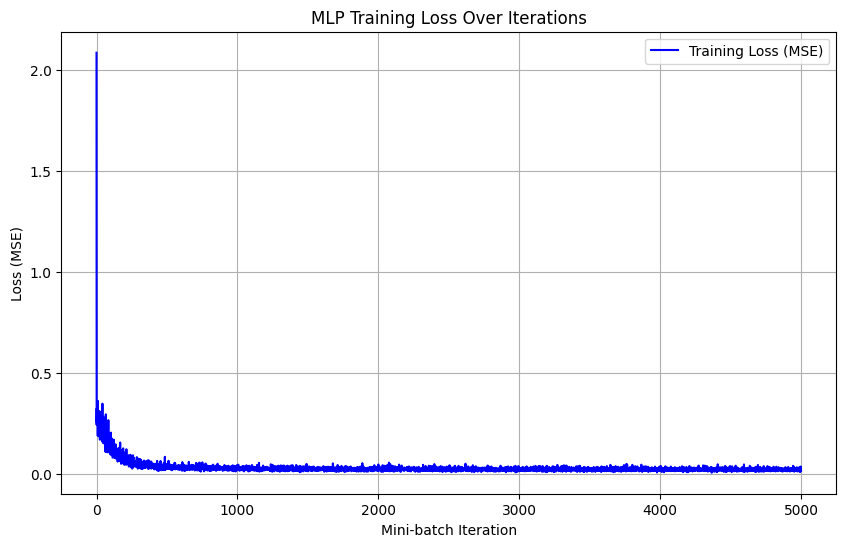

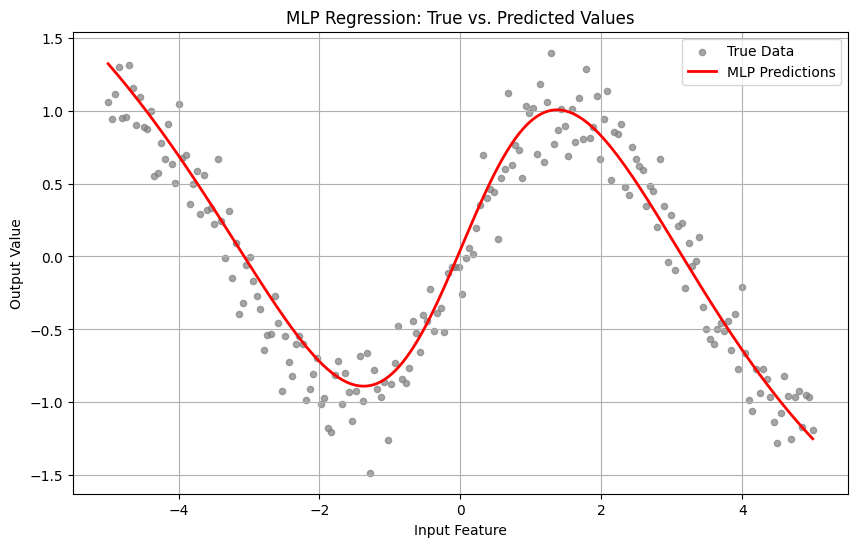

In [ ]:
# Define model parameters
model = {
    'n_features': 1,   # Number of input features
    'n_hidden': 10,    # Number of neurons in the hidden layer
    'n_output': 1,     # Number of output neurons
    'eta': 0.01,       # Learning rate
    'epochs': 500,     # Number of training epochs
    'minibatches': 10, # Number of mini-batches per epoch
    # 'alpha': 0.9,    # Momentum coefficient (uncomment if using momentum)
    # 'l1': 0.001,     # L1 regularization strength (uncomment for L1)
    # 'l2': 0.001      # L2 regularization strength (uncomment for L2)
}

# Generate synthetic data for a regression problem
num_samples = 200
X_train = np.linspace(-5, 5, num_samples).reshape(-1, 1) # Input feature
y_train = np.sin(X_train) + 0.2 * np.random.randn(num_samples, 1) # True output with noise

# Train the MLP model
print("\nStarting MLP training...")
trained_model, W1_trained, W2_trained = MLP_MSELIN_train(X_train, y_train, model)
print("MLP training complete.")

# Plot the training loss history
plt.figure(figsize=(10, 6))
plt.plot(trained_model['cost_history'], label='Training Loss (MSE)', color='blue')
plt.xlabel('Mini-batch Iteration')
plt.ylabel('Loss (MSE)')
plt.title('MLP Training Loss Over Iterations')
plt.grid(True)
plt.legend()
plt.show()

# Make predictions on the training data
y_pred_train = MLP_MSELIN_predict(X_train, W1_trained, W2_trained).T # Transpose to match y_train shape

# Plot original data and MLP predictions
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, label='True Data', color='gray', alpha=0.7, s=20)
plt.plot(X_train, y_pred_train, label='MLP Predictions', color='red', linewidth=2)
plt.xlabel('Input Feature')
plt.ylabel('Output Value')
plt.title('MLP Regression: True vs. Predicted Values')
plt.grid(True)
plt.legend()
plt.show()
